In [30]:

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from ast import arg
import matplotlib.pyplot as plt
from tqdm import tqdm

import scipy

def fit(xs, y, optim_f, init_grid, top_k=500, n_proc=8, tol=None, disp=False, maxiter=None):
        _, _, brute_xs, brute_ys = scipy.optimize.brute(optim_f, init_grid, args=(xs, y), full_output=True, finish=None, Ns=1, workers=-1)

        brute_xs = brute_xs.reshape(brute_xs.shape[0], -1)
        brute_ys = brute_ys.reshape(-1)

        top_idxs = np.argsort(brute_ys)[:top_k]
        top_xs = brute_xs[:, top_idxs]
        # top_ys = brute_ys[top_idxs]
        preds = []
        for i in tqdm(range(top_xs.shape[1])):
            options = {'disp': disp}
            if maxiter: options['maxiter'] = maxiter
            pred = scipy.optimize.minimize(optim_f, top_xs[:, i], args=(xs, y), method='L-BFGS-B', tol=tol, options=options).x
            loss = optim_f(pred, xs, y)
            # print(pred, loss)
            preds.append((pred, loss))
        return sorted(preds, key=lambda x: x[1])[0][0]

def power_law_with_const_min(args, *params):
    x,y = params
    a,b,c = args
    # return ((power_law_with_const(x,a,b,c) - y) ** 2).mean()
    with np.errstate(invalid='ignore', divide='ignore'):
        return ((np.log(power_law_with_const(x,a,b,c) / y)) ** 2).mean()

def power_law_with_const(x, a, b, c): return c * (1 + (x/b)**(-a))


100%|██████████| 125/125 [00:01<00:00, 117.25it/s]


loss 0.005570168965138759


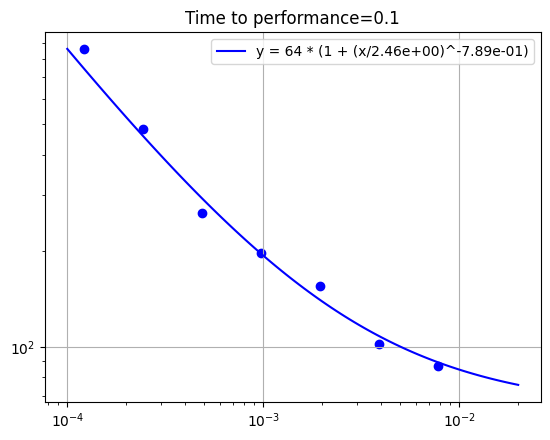

In [37]:
# Pareto fit 

n_parallel = np.array([1024, 2048, 4096, 8192, 16384, 32768, 65536])
utd = 1/n_parallel * 8
time_to_01 = np.array([87, 102, 155, 196, 262, 483, 860])
fit_data_points = [1, 2, 3, 4, 5]
plot_data_points = [0, 1, 2, 3, 4, 5, 6]

scaling = [1000, 1]
fitted_params = fit(utd[fit_data_points] * scaling[0], time_to_01[fit_data_points] * scaling[1], power_law_with_const_min,
                     [slice(-4, 4, 1.6),slice(1e-5, 5e-4, 1e-4),slice(-10, 10, 4)], maxiter=100)
print('loss', power_law_with_const_min(fitted_params, utd[fit_data_points] * scaling[0], time_to_01[fit_data_points] * scaling[1]))
a, b, c = fitted_params
x_smooth = np.logspace(-1, 1.3, 100)
y_fitted = power_law_with_const(x_smooth, a, b, c)
  
plt.title('Time to performance=0.1')
plt.scatter(utd[plot_data_points], time_to_01[plot_data_points], color='blue')
plt.plot(x_smooth / scaling[0], y_fitted / scaling[1], 'b-', label=f'y = {c:.0f} * (1 + (x/{b:.2e})^-{a:.2e})')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()

In [25]:
# Extrapolate

def get_lr(n_parallel):
    utd = 8/n_parallel * scaling[0]  # Scale UTD ratio same as training data
    predicted_lr = power_law_with_const(utd, a, b, c) / scaling[1]  # Unscale the prediction
    return predicted_lr

print(f'Predicted learning rate for n_parallel=131072: {get_lr(131072):.2e}')
print(f'Predicted learning rate for n_parallel=65536: {get_lr(65536):.2e}')
print(f'Predicted learning rate for n_parallel=32768: {get_lr(32768):.2e}')


Predicted learning rate for n_parallel=131072: 3.78e-04
Predicted learning rate for n_parallel=65536: 3.18e-04
Predicted learning rate for n_parallel=32768: 2.67e-04
